In [2]:
%pip install librosa scikit-learn matplotlib datasets

Note: you may need to restart the kernel to use updated packages.


In [52]:
import pandas as pd
df = pd.read_csv('/home/ec2-user/SageMaker/stt-split-audio/STT_HS/segments_hs_19.csv')

In [53]:
df['file_path'] = df['file_name'].apply(lambda x: f"/home/ec2-user/SageMaker/stt-split-audio/STT_HS/segments_hs/{x}.wav")

In [54]:
df = df[['file_path', 'audio_duration', 'inference_transcript', 'url']]

In [55]:
df = df.head(500)

In [56]:
from datasets import Dataset
dataset = Dataset.from_pandas(df)

In [57]:
dataset.map()

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Dataset({
    features: ['file_path', 'audio_duration', 'inference_transcript', 'url'],
    num_rows: 500
})

In [58]:
from datasets import Dataset
import pandas as pd
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import librosa
import numpy as np
import torch

# Initialize the processor and model spsither/wav2vec2_run10.840
processor = Wav2Vec2Processor.from_pretrained("spsither/wav2vec2_run10.840")
model = Wav2Vec2Model.from_pretrained("spsither/wav2vec2_run10.840")

# Define a function to load and preprocess audio
def preprocess_audio(batch):
    speech_array, sampling_rate = librosa.load(batch["file_path"], sr=16000)
    batch["speech"] = speech_array
    batch["sampling_rate"] = sampling_rate
    return batch

# Define a function for feature extraction
def extract_features(batch):
    # Process the batch of audio inputs
    inputs = processor(batch["speech"], sampling_rate=16000, return_tensors="pt", padding=True)

    # Move the batch to the same device as the model
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Extract features
    with torch.no_grad():
        features = model(**inputs).last_hidden_state

    # Convert features to numpy and take the mean across the time dimension
    batch["features"] = features.cpu().numpy().mean(axis=1)
    return batch

# Assuming df is your DataFrame and it has a column 'file_path' with the audio file paths
# Convert the DataFrame to a Hugging Face Dataset
dataset = Dataset.from_pandas(df)

# Apply preprocessing to load the audio files
dataset = dataset.map(preprocess_audio, batched=False)  # Process files individually to load audio

# Extract features in batches
dataset = dataset.map(extract_features, batched=True, batch_size=8)

# Convert the extracted features into a numpy array
features_array = np.array(dataset["features"])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

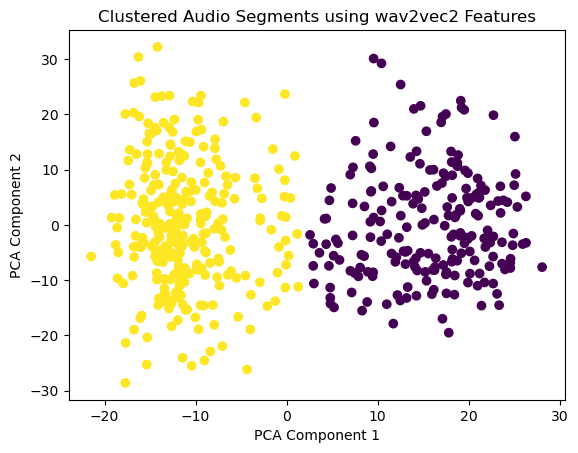

In [59]:
# Since wav2vec2 features might be high-dimensional, you can use PCA for dimensionality reduction
# Dimensionality Reduction
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_array)
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
reduced_features = pca.fit_transform(features_scaled)

# Clustering
kmeans = KMeans(n_clusters=2)  # Adjust based on your needs
kmeans.fit(reduced_features)
labels = kmeans.labels_

# Visualization
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clustered Audio Segments using wav2vec2 Features')
plt.show()

In [60]:
pd.set_option('display.max_colwidth', None)

In [63]:
df[labels == 0].tail()

,file_path,audio_duration,inference_transcript,url
492,/home/ec2-user/SageMaker/stt-split-audio/STT_HS/segments_hs/STT_HS0002_0122_708910_to_710926.wav,2.016,གཙོ་བོ་ཨ་རི་པི་པྀར་གོ་ཧྥོ་རེ་་རདཡ།,https://d38pmlk0v88drf.cloudfront.net/wav16k/STT_HS0002_0122_708910_to_710926.wav
493,/home/ec2-user/SageMaker/stt-split-audio/STT_HS/segments_hs/STT_HS0002_0123_710958_to_714542.wav,3.584,ཝི་དེ་དི་ས་པི་རེ་པ་གོ་ཡིག་འདུག་ད་ངས་དེ་་བྷོ་ཨེ་འདྲའི་ར་ཡིན།,https://d38pmlk0v88drf.cloudfront.net/wav16k/STT_HS0002_0123_710958_to_714542.wav
494,/home/ec2-user/SageMaker/stt-split-audio/STT_HS/segments_hs/STT_HS0002_0124_714820_to_718813.wav,3.993,ས་ལ་ཆསི་ར་ཡར་དིསི་དགོས་སོང་ལབ་ད་ད། ང་བྷོ་ལིབ་མེད།,https://d38pmlk0v88drf.cloudfront.net/wav16k/STT_HS0002_0124_714820_to_718813.wav
495,/home/ec2-user/SageMaker/stt-split-audio/STT_HS/segments_hs/STT_HS0002_0125_719035_to_725930.wav,6.895,་རི་ཡ་དུས་སོ་ད་རོ་ཊ་ཤོན་ཅི་རྡོག་སུ་ཝར་ད་མགོ་འགྲོ་དུས་ཨིན་ཌ་ོལས་ཧཋ་ད་མ་་་ཋ་རས།,https://d38pmlk0v88drf.cloudfront.net/wav16k/STT_HS0002_0125_719035_to_725930.wav
496,/home/ec2-user/SageMaker/stt-split-audio/STT_HS/segments_hs/STT_HS0002_0126_726663_to_730127.wav,3.464,ཨེ་ནས་ད་ལྟད་མི་ཡིན་ན་ྷེ་ལ་ཇ་ནན་ག་་ཝོ་ཌི་ད་མ་མང་ལུ་ེ།,https://d38pmlk0v88drf.cloudfront.net/wav16k/STT_HS0002_0126_726663_to_730127.wav


In [64]:
df[labels == 1].tail()

,file_path,audio_duration,inference_transcript,url
486,/home/ec2-user/SageMaker/stt-split-audio/STT_HS/segments_hs/STT_HS0002_0116_679661_to_686861.wav,7.200,དེ་ཚོགས་ནས་ཨེ་ནས་ཕག་པ་དེ་ཚོ་ཡར་ལོག་འགྲོ་གི་རེད། ཨེ་ནས་ང་ཚོ་ལོ་སགྱོན་པ་དེ་ཚོ་ནང་མཇལ་ཁ་མར་ཡོངཔ་ར་ན་སྐོར་ག་འགྲོ་ག་ཡོད་མ་རཱ པོ་ར་འགྲོ་གི་ཡོད་མ་རེད་དེ་མི་ག་ཚོད་སེ་འགྲོ་ི་ཡོད་རེད།,https://d38pmlk0v88drf.cloudfront.net/wav16k/STT_HS0002_0116_679661_to_686861.wav
487,/home/ec2-user/SageMaker/stt-split-audio/STT_HS/segments_hs/STT_HS0002_0117_687278_to_690030.wav,2.752,ང་ཚོ་སཔོ་ར་མར་ཡོང་ཡིན་དུས་མི་ལྔ་བཅུ་རྩེད་རྒྱོ་ཡོད་རེད་ལབ།,https://d38pmlk0v88drf.cloudfront.net/wav16k/STT_HS0002_0117_687278_to_690030.wav
497,/home/ec2-user/SageMaker/stt-split-audio/STT_HS/segments_hs/STT_HS0002_0127_730435_to_735674.wav,5.239,ད་ད་ལྟ་མི་བརྒྱ་དག་སི་ཡོད་རེད་བ། མདང་ོ་རྒྱ་གར་ལ་འགྲོ་གི་རེད། ཨ་ཁོང་ཚོ་ག་འདྲའི་ག་འདྲའི་ཐུག་ག་འགྲོ་ག། ད་དཔེ་འགྲོ་གནང་།,https://d38pmlk0v88drf.cloudfront.net/wav16k/STT_HS0002_0127_730435_to_735674.wav
498,/home/ec2-user/SageMaker/stt-split-audio/STT_HS/segments_hs/STT_HS0002_0128_736902_to_744769.wav,7.867,མི་རྒྱ་ཚོ་ང་ཚོ་ལུང་པ་ལ་བྲོ་བའ་ྱར་ནས་ཨེ་ནས་ཚོང་ལ་འགྲོ་དགོས་རེད་བ་ལ། ཨེ་ནས་ཚོང་འགྲོརྟག་ླབ་ག་རེད་ད་སྤུན་ག་སྤུན་རྒྱ་སྡུག་ནས་འགྲོ་དགིས་རེད་བ་ལབ་གོ་རེད། ད་ང་རང་ཚོ་རྣམ་འམྱལ་ལ་འགྲོ་ན་ཨེ་འདྲའི་འགྲོ་གི་འདུག་བ།,https://d38pmlk0v88drf.cloudfront.net/wav16k/STT_HS0002_0128_736902_to_744769.wav
499,/home/ec2-user/SageMaker/stt-split-audio/STT_HS/segments_hs/STT_HS0002_0129_745076_to_754616.wav,9.540,དེ་འགྲོ་གི་ཡ་ན་ན་ཡོང་ན་ཁོ་ཚོ་ཡར་ལང་པགས་པ་དེ་ཚོ་ལོག དེ་ང་ཚོ་མར་ཡོངྱི་ད་དགུ་པ་བཅུ་བ་ལ་ཚོང་ལ་ཡོང་གི་རེད། དེ་ནང་དགག་གི་མ་རེད། ད་ཁོ་དགུ་བ་བཅུ་པ་ལ་ཁོ་ཚོ་མགྱོགས་པ་ལོག་འགྲོ་གི་རེད། ང་ཚོ་མར་ཡོང་རེད།,https://d38pmlk0v88drf.cloudfront.net/wav16k/STT_HS0002_0129_745076_to_754616.wav
